In [1]:
import os, sys
sys.path.append('../')
import warnings
import optuna
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from functools import partial
from optuna.samplers import TPESampler
from optuna.pruners import NopPruner
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from utils.modeling import fit_model
from utils.evaluate import get_dpc_clusters
from utils.evaluate import get_dpc_unassigned
from utils.evaluate import get_jsdiv

c:\Users\ccrea\miniconda3\envs\revelio-assignment\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pth = os.path.join('..', 'data', 'training_us.gpkg')
gdf_us = gpd.read_file(pth)

In [3]:
# world equidistant projection (x,y)
crs = gdf_us.crs
gdf_us.to_crs('EPSG:4087', inplace = True)
gdf_us['x'] = gdf_us.geometry.x
gdf_us['y'] = gdf_us.geometry.y
gdf_us['w'] = np.log10(gdf_us.population)
gdf_us.to_crs(crs, inplace = True); gdf_us

,city,state,country,latitude,longitude,population,msa,fold,geometry,x,y,w
0,mahopac,new york,united states,41.37232,-73.73346,8369,New York-Northern New Jersey-Long Island NY-NJ...,1,POINT (-8207971.222 5067414.863),-8.207971e+06,4.605546e+06,3.922674
1,seven hills,ohio,united states,41.39533,-81.67624,11690,None,2,POINT (-9092157.447 5070828.79),-9.092157e+06,4.608107e+06,4.067815
2,new martinsville,west virginia,united states,39.64452,-80.85760,5218,None,1,POINT (-9001026.859 4814418.565),-9.001027e+06,4.413208e+06,3.717504
3,jacksonville,oregon,united states,42.31346,-122.96699,2883,Jacksonville FL MSA,1,POINT (-13688622.711 5208050.499),-1.368862e+07,4.710313e+06,3.459845
4,tigerville,south carolina,united states,35.06845,-82.36845,1312,Greenville-Mauldin-Easley SC MSA,1,POINT (-9169213.911 4173187.121),-9.169214e+06,3.903802e+06,3.117934
...,...,...,...,...,...,...,...,...,...,...,...,...
7151,mansfield,texas,united states,32.56319,-97.14168,64274,Mansfield OH MSA,2,POINT (-10813762.352 3837467.237),-1.081376e+07,3.624918e+06,4.808035
7152,belfast,maine,united states,44.42591,-69.00642,6682,None,1,POINT (-7681759.536 5531591.056),-7.681760e+06,4.945470e+06,3.824906
7153,flushing,michigan,united states,43.06308,-83.85107,8086,Wheeling WV-OH MSA,1,POINT (-9334258.415 5321578.2),-9.334258e+06,4.793760e+06,3.907734
7154,stone mountain,georgia,united states,33.80816,-84.17020,6109,Atlanta-Sandy Springs-Marietta GA MSA,2,POINT (-9369783.804 4003071.597),-9.369784e+06,3.763507e+06,3.785970


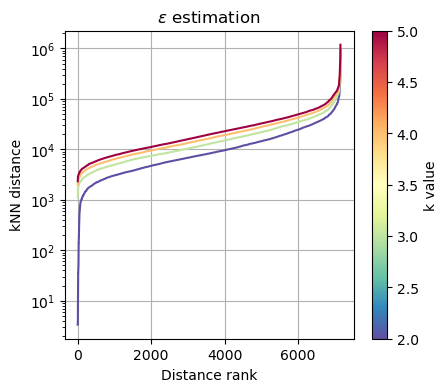

In [4]:
# estimate DBSCAN max distances
X = gdf_us[['x', 'y']].values
kvals = np.arange(2, 6)
cmap = plt.cm.Spectral_r
norm = Normalize(vmin = kvals.min(), vmax = kvals.max())
sm = ScalarMappable(cmap = cmap, norm = norm)

# k-neighbor distances
fig, ax = plt.subplots(1, 1, figsize = (4.66, 4))
for k in kvals:
    nbrs = NearestNeighbors(n_neighbors = k).fit(X)
    d, _ = nbrs.kneighbors(X)
    d_sorted = np.sort(d[:, k - 1])
    ax.plot(d_sorted, label = f'k = {k}', c = sm.to_rgba(k))

ax.set_xlabel('Distance rank')
ax.set_ylabel('kNN distance')
ax.set_title(r'$\epsilon$ estimation')
ax.set_yscale('log')
plt.colorbar(sm, ax = ax, label = 'k value')
ax.grid(True)
plt.show()

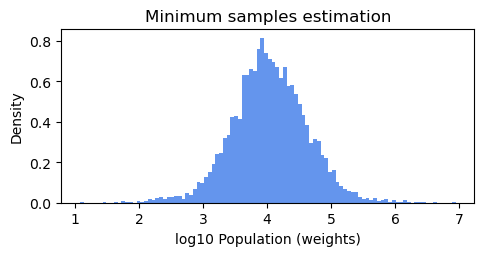

In [5]:
# estimate DBSCAN min samples
fig, ax = plt.subplots(1, 1, figsize = (5.33, 2.25))
ax.hist(gdf_us.w,
        bins = 100,
        facecolor = 'cornflowerblue',
        density = True)
ax.set_title('Minimum samples estimation')
ax.set_xlabel('log10 Population (weights)')
ax.set_ylabel('Density')
plt.show()

In [6]:
######################################################
########## define optuna training objective ##########
######################################################
def objective(trial, gdf: gpd.GeoDataFrame):

    # compute & log metrics
    def process_fold(gdf_fold: gpd.GeoDataFrame,
                     fold_name: str,
                     alpha_js: float
                     ) -> float: 
        gdf_fold = gdf_fold.copy()

        # frac data assigned to clusters
        ix_clus = gdf_fold.cluster >= 0
        frac_clus = ix_clus.mean()
        
        # distance per capita — clusters
        gdf_fold_clus = gdf_fold.loc[ix_clus].copy()
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', category = FutureWarning)
            gdf_fold_clus = get_dpc_clusters(gdf_fold_clus, 'cluster')
        
        # distance per capita — unassigned
        gdf_fold_other = gdf_fold.loc[~ix_clus].copy()
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', category = FutureWarning)
            gdf_fold_other = get_dpc_unassigned(gdf_fold_other, gdf_fold_clus, 'cluster')
        
        # Jensen-Shannon divergence & per-category entropy
        jsdiv, S_clus, S_other = get_jsdiv(gdf_fold_clus,
                                           gdf_fold_other,
                                           'log10_dpc',
                                           n_bins = 100,
                                           return_S = True)
        
        # combined score
        score = (alpha_js * jsdiv + S_clus + S_other) / (2 + alpha_js)
        
        # log values
        trial.set_user_attr(f'{fold_name}_frac', frac_clus)
        trial.set_user_attr(f'{fold_name}_nclus', gdf_fold_clus.cluster.nunique())
        trial.set_user_attr(f'{fold_name}_clus_dpc', gdf_fold_clus.log10_dpc.mean())
        trial.set_user_attr(f'{fold_name}_other_dpc', gdf_fold_other.log10_dpc.mean())
        trial.set_user_attr(f'{fold_name}_jsdiv', jsdiv)
        trial.set_user_attr(f'{fold_name}_clus_S', S_clus)
        trial.set_user_attr(f'{fold_name}_other_S', S_other)
        trial.set_user_attr(f'{fold_name}_score', score)
        return score

    # two folds for unsupervised model selection
    gdf1 = gdf.loc[gdf.fold == 1].copy()
    gdf2 = gdf.loc[gdf.fold == 2].copy()

    # sample parameter values
    clf_name = trial.suggest_categorical('classifier', ['DBSCAN', 'HDBSCAN'])
    eps_DBSCAN = trial.suggest_float('eps_DBSCAN', 1e4, 5e4, log = True)  # 10-50 km
    min_samples_DBSCAN = trial.suggest_int('min_samples_DBSCAN', 2, 6)
    min_cluster_size_HDBSCAN = trial.suggest_int('min_cluster_size_HDBSCAN', 2, 20)
    min_samples_HDBSCAN = trial.suggest_int('min_samples_HDBSCAN', 1, 19)
    cluster_selection_epsilon_HDBSCAN = trial.suggest_float('cluster_selection_epsilon_HDBSCAN', 1e2, 1e4)
    alpha_js = trial.suggest_float('alpha_js', .1, 1.)
    gamma_density = trial.suggest_float('gamma_density', 1e-4, 1e-2, log = True)

    # require min_samples < min_cluster_size (HDBSCAN only)
    if (clf_name == 'HDBSCAN') and (min_samples_HDBSCAN >= min_cluster_size_HDBSCAN):
        raise optuna.exceptions.TrialPruned()
    
    # fit models & compute scores
    scores = []
    for i, gdf_fold in enumerate((gdf1, gdf2), start = 1):
        gdf_fold = fit_model(
            gdf_fold, clf_name,
            gamma_density = gamma_density,
            eps_DBSCAN = eps_DBSCAN,
            min_samples_DBSCAN = min_samples_DBSCAN,
            min_cluster_size_HDBSCAN = min_cluster_size_HDBSCAN,
            min_samples_HDBSCAN = min_samples_HDBSCAN,
            cluster_selection_epsilon_HDBSCAN = cluster_selection_epsilon_HDBSCAN
        )
        score_fold = process_fold(gdf_fold, f'fold{i}', alpha_js)
        scores.append(score_fold)
    avg_score = np.asarray(scores).mean()
    trial.set_user_attr('avg_score', avg_score)
    return avg_score

In [ ]:
# optimize parameters
pth = os.path.join('..', 'logs', 'density_modeling_optuna.db')
sampler = TPESampler(seed = 42, multivariate = True, group = True)
study = optuna.create_study(sampler = sampler,
                            pruner = NopPruner(),
                            direction = 'maximize',
                            study_name = 'density_models',
                            storage = f'sqlite:///{pth}')
study.optimize(partial(objective, gdf = gdf_us), n_trials = 500)

c:\Users\ccrea\miniconda3\envs\revelio-assignment\Lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\ccrea\miniconda3\envs\revelio-assignment\Lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-06-16 20:09:51,195] A new study created in RDB with name: density_models
[I 2025-06-16 20:09:52,493] Trial 0 finished with value: 0.7031936389028963 and parameters: {'classifier': 'HDBSCAN', 'eps_DBSCAN': 32481.928697702926, 'min_samples_DBSCAN': 4, 'min_cluster_size_HDBSCAN': 4, 'min_samples_HDBSCAN': 3, 'cluster_selection_epsilon_HDBSCAN': 675.0277604651747, 'alpha_js': 0.8795585311974417, 'gamma_density': 0.0015930522616241021}. Best is trial 0 with value: 0.7031936389028963.
[I 2025-06-16 20:09:53,359] Trial 1 finished with value: 0.

In [8]:
study.best_params

{'classifier': 'DBSCAN',
 'eps_DBSCAN': 24574.651584047293,
 'min_samples_DBSCAN': 6,
 'min_cluster_size_HDBSCAN': 8,
 'min_samples_HDBSCAN': 2,
 'cluster_selection_epsilon_HDBSCAN': 3740.641597651327,
 'alpha_js': 0.1317350287576371,
 'gamma_density': 0.005257507370438514}

In [9]:
study.best_trial.user_attrs

{'avg_score': 0.8479418166820902,
 'fold1_clus_S': 0.8669136266269339,
 'fold1_clus_dpc': -1.4868023833586697,
 'fold1_frac': 0.7723735408560312,
 'fold1_jsdiv': 0.7448393289577437,
 'fold1_nclus': 333,
 'fold1_other_S': 0.833367889783262,
 'fold1_other_dpc': 0.18056525896298456,
 'fold1_score': 0.8436334359427223,
 'fold2_clus_S': 0.8635401841115105,
 'fold2_clus_dpc': -1.4602431509949818,
 'fold2_frac': 0.7731871838111298,
 'fold2_jsdiv': 0.730560573765989,
 'fold2_nclus': 323,
 'fold2_other_S': 0.8569909968031649,
 'fold2_other_dpc': 0.2198996655707969,
 'fold2_score': 0.852250197421458}

In [ ]:
# cluster using best parameter values
gdf_us = fit_model(gdf_us,
            clf_name = study.best_params['classifier'],
            gamma_density = study.best_params['gamma_density'],
            eps_DBSCAN = study.best_params['eps_DBSCAN'],
            min_samples_DBSCAN = study.best_params['min_samples_DBSCAN']
            )

In [11]:
# assign cluster names (biggest city)
cluster_names = (gdf_us[gdf_us.cluster >= 0]
                 .sort_values('population', ascending = False)
                 .drop_duplicates('cluster')
                 .set_index('cluster')
                 .apply(lambda row: f'{row.city} {row.state} {row.country}', axis = 1))
gdf_us['cluster_name'] = gdf_us.cluster.map(cluster_names)
gdf_us.loc[gdf_us.cluster < 0, 'cluster_name'] = pd.NA
gdf_us['cluster'] = gdf_us.cluster_name.astype('string')
gdf_us.drop(columns = ['cluster_name', 'x', 'y', 'w'], inplace = True); gdf_us

,city,state,country,latitude,longitude,population,msa,fold,geometry,cluster
0,mahopac,new york,united states,41.37232,-73.73346,8369,New York-Northern New Jersey-Long Island NY-NJ...,1,POINT (-8207971.222 5067414.863),new york city new york united states
1,seven hills,ohio,united states,41.39533,-81.67624,11690,None,2,POINT (-9092157.447 5070828.79),cleveland ohio united states
2,new martinsville,west virginia,united states,39.64452,-80.85760,5218,None,1,POINT (-9001026.859 4814418.565),<NA>
3,jacksonville,oregon,united states,42.31346,-122.96699,2883,Jacksonville FL MSA,1,POINT (-13688622.711 5208050.499),medford oregon united states
4,tigerville,south carolina,united states,35.06845,-82.36845,1312,Greenville-Mauldin-Easley SC MSA,1,POINT (-9169213.911 4173187.121),asheville north carolina united states
...,...,...,...,...,...,...,...,...,...,...
7151,mansfield,texas,united states,32.56319,-97.14168,64274,Mansfield OH MSA,2,POINT (-10813762.352 3837467.237),dallas texas united states
7152,belfast,maine,united states,44.42591,-69.00642,6682,None,1,POINT (-7681759.536 5531591.056),belfast maine united states
7153,flushing,michigan,united states,43.06308,-83.85107,8086,Wheeling WV-OH MSA,1,POINT (-9334258.415 5321578.2),detroit michigan united states
7154,stone mountain,georgia,united states,33.80816,-84.17020,6109,Atlanta-Sandy Springs-Marietta GA MSA,2,POINT (-9369783.804 4003071.597),atlanta georgia united states


In [ ]:
# testing data — international
pth = os.path.join('..', 'data', 'testing_intl.gpkg')
gdf_intl = gpd.read_file(pth)

In [15]:
# world equidistant projection (x,y)
crs = gdf_intl.crs
gdf_intl.to_crs('EPSG:4087', inplace = True)
gdf_intl['x'] = gdf_intl.geometry.x
gdf_intl['y'] = gdf_intl.geometry.y
gdf_intl['w'] = np.log10(gdf_intl.population)
gdf_intl.to_crs(crs, inplace = True); gdf_intl

,city,state,country,latitude,longitude,population,msa,geometry,x,y,w
0,sint anthonis,north brabant,netherlands,51.62667,5.88194,3340,None,POINT (654774.566 6732902.058),6.547746e+05,5.747055e+06,3.523746
1,machali,o higgins region,chile,-34.18082,-70.64933,27595,None,POINT (-7864647.44 -4053107.653),-7.864647e+06,-3.804991e+06,4.440830
2,jankowice,silesia,poland,50.00090,18.98901,2840,None,POINT (2113846.924 6446431.707),2.113847e+06,5.566075e+06,3.453318
3,fjerritslev,north denmark,denmark,57.08822,9.26622,3332,None,POINT (1031510.892 7778171.492),1.031511e+06,6.355032e+06,3.522705
4,palmanova,balearic islands,spain,39.52470,2.53922,7040,None,POINT (282664.677 4797111.472),2.826647e+05,4.399869e+06,3.847573
...,...,...,...,...,...,...,...,...,...,...,...
16866,cacoal,rondonia,brazil,-11.43861,-61.44722,55560,None,POINT (-6840273.241 -1281884.032),-6.840273e+06,-1.273340e+06,4.744762
16867,moulins,auvergne rhone alpes,france,46.56459,3.33243,23095,None,POINT (370964.411 5871291.422),3.709644e+05,5.183546e+06,4.363518
16868,wymondham,england,united kingdom,52.75978,-0.74055,500,None,POINT (-82437.649 6938686.748),-8.243765e+04,5.873192e+06,2.698970
16869,ubud,bali,indonesia,-8.50980,115.26540,28373,None,POINT (12831285.634 -950808.768),1.283129e+07,-9.473066e+05,4.452905


In [ ]:
# cluster international cities
gdf_intl = fit_model(gdf_intl,
            clf_name = study.best_params['classifier'],
            gamma_density = study.best_params['gamma_density'],
            eps_DBSCAN = study.best_params['eps_DBSCAN'],
            min_samples_DBSCAN = study.best_params['min_samples_DBSCAN']
            )

In [17]:
# assign cluster names (biggest city)
cluster_names = (gdf_intl[gdf_intl.cluster >= 0]
                 .sort_values('population', ascending = False)
                 .drop_duplicates('cluster')
                 .set_index('cluster')
                 .apply(lambda row: f'{row.city} {row.state} {row.country}', axis = 1))
gdf_intl['cluster_name'] = gdf_intl.cluster.map(cluster_names)
gdf_intl.loc[gdf_intl.cluster < 0, 'cluster_name'] = pd.NA
gdf_intl['cluster'] = gdf_intl.cluster_name.astype('string')
gdf_intl.drop(columns = ['cluster_name', 'x', 'y', 'w'], inplace = True); gdf_intl

,city,state,country,latitude,longitude,population,msa,geometry,cluster
0,sint anthonis,north brabant,netherlands,51.62667,5.88194,3340,None,POINT (654774.566 6732902.058),cologne north rhine westphalia germany
1,machali,o higgins region,chile,-34.18082,-70.64933,27595,None,POINT (-7864647.44 -4053107.653),santiago region metropolitana chile
2,jankowice,silesia,poland,50.00090,18.98901,2840,None,POINT (2113846.924 6446431.707),krakow lesser poland poland
3,fjerritslev,north denmark,denmark,57.08822,9.26622,3332,None,POINT (1031510.892 7778171.492),aars north denmark denmark
4,palmanova,balearic islands,spain,39.52470,2.53922,7040,None,POINT (282664.677 4797111.472),palma balearic islands spain
...,...,...,...,...,...,...,...,...,...
16866,cacoal,rondonia,brazil,-11.43861,-61.44722,55560,None,POINT (-6840273.241 -1281884.032),<NA>
16867,moulins,auvergne rhone alpes,france,46.56459,3.33243,23095,None,POINT (370964.411 5871291.422),nevers bourgogne franche comte france
16868,wymondham,england,united kingdom,52.75978,-0.74055,500,None,POINT (-82437.649 6938686.748),london england united kingdom
16869,ubud,bali,indonesia,-8.50980,115.26540,28373,None,POINT (12831285.634 -950808.768),denpasar bali indonesia


In [ ]:
# gdf_us.to_file(os.path.join('..', 'data', 'density_modeling', 'training_us.gpkg'), driver = 'GPKG')